In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sms-spam-collection-dataset/spam.csv


## Load the dataset and get rid of useless columns

In [2]:
#load the data
data = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
#get rid of useless columns
data = data[['v1','v2']]
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Let us check the distribution of classes

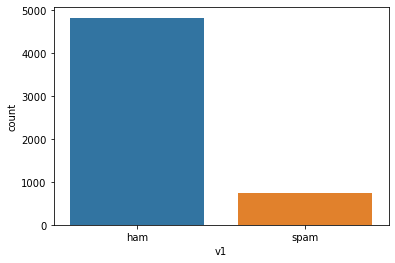

In [4]:
print(data.v1.value_counts())
sns.countplot(data.v1)

#### The dataset in imbalanced. Accuracy will not be a good metric. We need to evaluate the model using precision/recall, F1-score, cohen-kappa score etc. We might need to perform undersampling/oversampling. We shall look at it later. We change 'ham' to label 0, 'spam' to label 1

In [5]:
def set_label(value):
    return 0 if value == 'ham' else 1
data['v1'] = data['v1'].apply(set_label)

In [6]:
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Data cleaning:
#### 1. remove urls
#### 2. remove emails
#### 3. remove tags
#### 4. remove punctuations
#### 5. remove stopwords
#### 6. lemmatize/stem

In [7]:
def remove_punctuation(text): 
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator)

In [8]:
def remove_tags(text):
  return re.sub('<.*?>'," ",text)

In [9]:
def remove_numbers(text):
  return re.sub('[0-9]+','number',text)

In [12]:
def remove_urls(text):
  return re.sub('https?:\S+','link',text)


In [13]:
def remove_emails(text):
    return re.sub('\S+@\S+','email',text)

In [14]:
data['v2'] = data['v2'].apply(remove_urls)
data['v2'] = data['v2'].apply(remove_tags)
data['v2'] = data['v2'].apply(remove_emails)
data['v2'] = data['v2'].apply(remove_punctuation)
data['v2'] = data['v2'].apply(remove_numbers)

In [15]:
data['v2'] = data['v2'].apply(lambda word : word.lower())

In [16]:
data.head()

,v1,v2
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in number a wkly comp to win fa cup...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...


In [17]:
from nltk.corpus import stopwords
stops = stopwords.words('english')

In [18]:
def remove_stopwords(text):
    cleaned = []
    for word in text.split():
        if word not in stops:
            cleaned.append(word)
    return " ".join(cleaned)

In [19]:
data['v2'] = data['v2'].apply(remove_stopwords)

In [20]:
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
  lemmas = []
  for word in text.split():
    lemmas.append(lemmatizer.lemmatize(word))
  return " ".join(lemmas)

### Lemmatize and shuffle the dataset

In [21]:
data['v2'] = data['v2'].apply(lemmatize_words)
data = data.sample(frac=1).reset_index(drop=True)

In [22]:
X = data['v2'].values
y = data['v1'].values

In [23]:
#split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)
print('No. of training samples:',len(X_train))
print('No. of testing samples:',len(X_test))

No. of training samples: 3900
No. of testing samples: 1672


In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Tokenize the data into sequence of tokens. Then pad/truncate the data so that every sequence is of same length. 

In [25]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)
word_to_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)

In [26]:
vocab_size = len(word_to_index)
max_length = 50
embedding_dim = 100
padded_sequences = pad_sequences(sequences,maxlen=max_length,padding='post',truncating='post')

In [34]:
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test_sequences = pad_sequences(test_sequences,maxlen=max_length,padding='post',truncating='post')

## Set up the embedding matrix. We shall use 100 dimensional glove vectors.

In [29]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /kaggle/working/glove.6B.100d.txt

--2020-05-30 13:09:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/kaggle/working/glove.6B.100d.txt’

/kaggle/working/glo 100%[===================>] 331.04M   126MB/s    in 2.6s    

2020-05-30 13:09:17 (126 MB/s) - ‘/kaggle/working/glove.6B.100d.txt’ saved [347116733/347116733]



In [30]:
embeddings_index = {};
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [31]:
print(embeddings_matrix.shape)

(6703, 100)


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,SpatialDropout1D,LSTM,Bidirectional,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

## Define and compile the model. We shall use an LSTM network with dropouts to prevent overfitting

In [33]:
model = Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128,recurrent_dropout=0.2,dropout=0.2)),
    Dense(32,activation='relu'),
    Dense(1,activation='sigmoid')
])
optimizer = Adam(learning_rate=0.01)
callbacks = ReduceLROnPlateau(monitor='val_accuracy',patience=2,factor=0.5,min_lr=0.00001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           670300    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 913,053
Trainable params: 242,753
Non-trainable params: 670,300
_________________________________________________________________


In [35]:
epochs = 10
history = model.fit(padded_sequences,y_train,epochs=epochs,validation_data=(padded_test_sequences,y_test),batch_size=64,callbacks=[callbacks])

Train on 3900 samples, validate on 1672 samples
Epoch 1/10
3900/3900 [==============================] - 17s 4ms/sample - loss: 0.2028 - accuracy: 0.9272 - val_loss: 0.0946 - val_accuracy: 0.9707
Epoch 2/10
3900/3900 [==============================] - 11s 3ms/sample - loss: 0.1094 - accuracy: 0.9590 - val_loss: 0.0953 - val_accuracy: 0.9701
Epoch 3/10
3900/3900 [==============================] - 11s 3ms/sample - loss: 0.0803 - accuracy: 0.9710 - val_loss: 0.1061 - val_accuracy: 0.9719
Epoch 4/10
3900/3900 [==============================] - 11s 3ms/sample - loss: 0.0854 - accuracy: 0.9692 - val_loss: 0.0625 - val_accuracy: 0.9809
Epoch 5/10
3900/3900 [==============================] - 11s 3ms/sample - loss: 0.0682 - accuracy: 0.9779 - val_loss: 0.0671 - val_accuracy: 0.9809
Epoch 6/10
3900/3900 [==============================] - 11s 3ms/sample - loss: 0.0478 - accuracy: 0.9854 - val_loss: 0.0668 - val_accuracy: 0.9779
Epoch 7/10
3900/3900 [==============================] - 11s 3ms/sample

## Evaluate the model

In [37]:
from sklearn.metrics import classification_report,confusion_matrix,cohen_kappa_score
train_stats = model.evaluate(padded_sequences,y_train)
test_stats = model.evaluate(padded_test_sequences,y_test)
print('training accuracy:',train_stats[1]*100)
print('testing accuracy:',test_stats[1]*100)

y_pred = model.predict_classes(padded_test_sequences)
print(classification_report(y_test,y_pred))
print('Confusion matix:\n',confusion_matrix(y_test,y_pred))
print('Cohen-kappa score:',cohen_kappa_score(y_test,y_pred))

1672/1672 [==============================] - 1s 575us/sample - loss: 0.0840 - accuracy: 0.9833
training accuracy: 99.82051253318787
testing accuracy: 98.32535982131958
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1453
           1       0.98      0.89      0.93       219

    accuracy                           0.98      1672
   macro avg       0.98      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672

Confusion matix:
 [[1449    4]
 [  24  195]]
Cohen-kappa score: 0.9234700049367862


# Conclusion:
### Good results provided that the dataset was imbalanced.
### Cohen kappa score of 92.3